In [1]:
import pywt
import numpy as np
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

In [2]:
class dwt:
    def __init__(self, filter_size, h = None, g = None):
        if h is None:
            self.h = np.random.normal(1,2,filter_size)
        else:
            self.h = h
        
        if g is None:
            self.g = np.random.normal(1,2,filter_size)
        else:
            self.g = g
        
    def compute(self, input_):
        filter_bank = [self.h, self.g, np.flip(self.h), np.flip(self.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return pywt.dwt(input_, wavelet=my_wavelet)
    
    def inverse(self):
        return idwt(self)
    
    def update_weigths(self, hg, gg, lr = 0.001):
        self.h = self.h - lr*hg
        self.g = self.g - lr*gg

In [3]:
class idwt:
    def __init__(self, dwt):
        self.h = dwt.h
        self.g = dwt.g
    
    def compute(self, input_):
        ca,cd = input_
        filter_bank = [self.h, self.g, np.flip(self.h), np.flip(self.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return pywt.idwt(ca,cd, wavelet=my_wavelet)

In [4]:
def loss_function(h, g, x, x_, W):
    l1 = 0.5
    l2 = 0.5
    s1 = mean_squared_error(x, x_)
    s2 = np.sum(np.abs(W))
    s3 = lhg(h,g)
    return s1 + l1*s2 + l1*s3
    
def lhg(h, g):
    s1 = (np.sum(h**2) - 1)**2
    s2 = (np.sum(h) - math.sqrt(2))**2
    s3 = np.sum(g)**2
    return s1 + s2 + s3

In [5]:
def compute_gradient_h(h, g, x, loss_function, diff = 0.001):
    length = len(h)
    gradient = np.zeros(length)
    mask = np.zeros(length)
    for i in range(length):
        mask[i] = diff
        h_plus = h + mask
        h_minus = h - mask
        
        dwtp = dwt(1, h_plus, g)
        idwtp = dwtp.inverse()
        
        dwtm = dwt(1, h_minus, g)
        idwtm = dwtm.inverse()
        
        Wp = dwtp.compute(x)
        x_p = idwtp.compute(Wp)
        
        Wm = dwtm.compute(x)
        x_m = idwtm.compute(Wm)
        
        lossp = loss_function(h_plus, g, x, x_p, Wp)
        lossm = loss_function(h_minus, g, x, x_m, Wm)
        gradient[i] = (lossp - lossm)/diff
        
    return gradient

def compute_gradient_g(h, g, x, loss_function, diff = 0.001):
    length = len(g)
    gradient = np.zeros(length)
    mask = np.zeros(length)
    for i in range(length):
        mask[i] = diff
        g_plus = g + mask
        g_minus = g - mask
        
        dwtp = dwt(1, h, g_plus)
        idwtp = dwtp.inverse()
        
        dwtm = dwt(1, h, g_minus)
        idwtm = dwtm.inverse()
        
        Wp = dwtp.compute(x)
        x_p = idwtp.compute(Wp)
        
        Wm = dwtm.compute(x)
        x_m = idwtm.compute(Wm)
        
        lossp = loss_function(h, g_plus, x, x_p, Wp)
        lossm = loss_function(h, g_minus, x, x_m, Wm)
        gradient[i] = (lossp - lossm)/diff
        
    return gradient

def compute_gradient(h, g, x, loss_function, diff = 0.001):
    hg = compute_gradient_h(h, g, x, loss_function, diff)
    gg = compute_gradient_g(h, g, x, loss_function, diff)
    return (hg, gg)
    
    
    

In [15]:
class Model:
    def __init__(self,filter_size = 2**5):
        self.my_dwt = dwt(filter_size)
        self.my_idwt = self.my_dwt.inverse()
        self.losses = []
        self.min_loss = math.inf
        
    def fit(self, x, epochs = 100, learning_rate = 0.001, verbose = True, good_error = None, diff = 0.000001):
        best_h = self.my_dwt.h
        best_g = self.my_idwt.g
        for i in range(epochs):
            W = self.my_dwt.compute(x)
            x_ = self.my_idwt.compute(W)
            loss = mean_squared_error(x,x_)#loss_function(self.my_dwt.h, self.my_dwt.g, x, x_, W)
            self.losses.append(loss)
            if loss < self.min_loss:
                self.min_loss = loss
                best_h = self.my_dwt.h
                best_g = self.my_dwt.g
            
            if verbose:
                print('Epochs #' + str(i+1) + ": " + str(loss) + " loss")
            
            if not good_error is None and loss <= good_error:
                return
            
            hg, gg = compute_gradient(self.my_dwt.h, self.my_dwt.g, x, loss_function, diff)
            self.my_dwt.update_weigths(hg, gg, learning_rate)
        
        self.my_dwt = dwt(1, best_h, best_g)
        self.my_idwt = self.my_dwt.inverse()
        print("Best Loss", self.min_loss)
    
    def predict(self, x):
        W = self.my_dwt.compute(x)
        return self.my_idwt.compute(W)
    
        
            

In [28]:
model = Model(32)
indexes = np.arange(64)
x = np.sin(indexes)
print(x[:10])

[ 0.          0.84147098  0.90929743  0.14112001 -0.7568025  -0.95892427
 -0.2794155   0.6569866   0.98935825  0.41211849]


In [25]:
model.fit(x,epochs = 200, learning_rate=0.001)


Epochs #1: 11.721124992305299 loss
Epochs #2: 11.757550446342627 loss
Epochs #3: 12.367396392964114 loss
Epochs #4: 13.920357931293678 loss
Epochs #5: 22.796175431567832 loss
Epochs #6: 61.86572684696762 loss
Epochs #7: 191.52270594723052 loss
Epochs #8: 691.7806320320669 loss
Epochs #9: 2526.9824809439415 loss
Epochs #10: 14795.836327753661 loss
Epochs #11: 508428.36368021846 loss
Epochs #12: 16372563577.12385 loss
Epochs #13: 6.452597664288077e+23 loss
Epochs #14: 2.3954760315496568e+64 loss
Epochs #15: 2.3954760315496568e+64 loss
Epochs #16: 2.3954760315496568e+64 loss
Epochs #17: 2.3954760315496568e+64 loss
Epochs #18: 2.3954760315496568e+64 loss
Epochs #19: 2.3954760315496568e+64 loss
Epochs #20: 2.3954760315496568e+64 loss
Epochs #21: 2.3954760315496568e+64 loss
Epochs #22: 2.3954760315496568e+64 loss
Epochs #23: 2.3954760315496568e+64 loss
Epochs #24: 2.3954760315496568e+64 loss
Epochs #25: 2.3954760315496568e+64 loss
Epochs #26: 2.3954760315496568e+64 loss
Epochs #27: 2.3954760

11.721124992305299


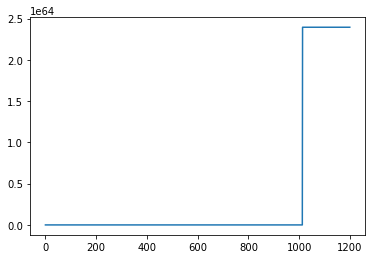

In [26]:
losses = np.array(model.losses)
min_ = np.amin(losses)
print(min_)
plt.plot(np.arange(len(model.losses)), model.losses)

[ 0.          0.84147098  0.90929743  0.14112001 -0.7568025  -0.95892427
 -0.2794155   0.6569866   0.98935825  0.41211849]
19112.402437413402
[ 0.          0.84147098  0.90929743  0.14112001 -0.7568025  -0.95892427
 -0.2794155   0.6569866   0.98935825  0.41211849]


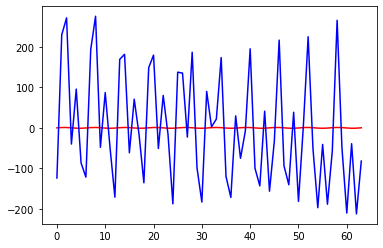

In [29]:
print(x[:10])
ll = model.predict(x)
print(mean_squared_error(ll,x))


plt.plot(indexes, x, c = 'r', label='orginal')
plt.plot(indexes, ll, c = 'b', label='aprendida')
print(x[:10])

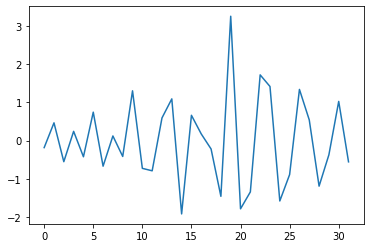

In [294]:
plt.plot(np.arange(len(model.my_dwt.g)), model.my_dwt.g)